In [1]:
import sys 
sys.path.append('../..')
# sys.path.append('/Users/patroklos/cox')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
from torch import sigmoid as sig
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime
from delphi.stats import truncated_logistic_regression
from delphi.oracle import oracle
from delphi import train
from delphi.utils import constants as consts

# set default tensor type 
# ch.set_default_tensor_type(ch.cuda.FloatTensor)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

# Constants

In [22]:
TRUNCATED_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionTruncated/'
STANDARD_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionStandard/'

TRUNCATED_EVAL_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionTruncatedTest/'
STANDARD_EVAL_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionStandardTest/'

GUMBEL_CE_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionGumbelCE'

# Helper Functions

In [3]:
# membership oracles
class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()
    
class DNN_Logit_Ball(oracle): 
    """
    Truncation ball placed on DNN logits.
    INTUITION: logits that are neither very large nor very small insinuate
    that the classification is not 
    """
    def __init__(self, lower, upper): 
        self.lower = lower 
        self.upper = upper
        
    def __call__(self, x): 
        return ((x < self.lower) | (x > self.upper)).float()
        

class Identity(oracle): 
    def __call__(self, x): 
        return ch.ones(x.size())
    
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
            ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices], y[indices]
            alpha = x_trunc.size(0) / X.size(0)

            # all synthetic data 
            ds = TensorDataset(x_trunc, y_trunc)
            # split ds into training and validation data sets - 80% training, 20% validation
            train_length = int(len(ds)*.8)
            val_length = len(ds) - train_length
            train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
            # train and validation loaders
            train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

            # test dataset
            x_test = X[~indices]
            y_test = y[~indices]
            test_ds = TensorDataset(x_test, y_test)
            test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            
    return ground_truth, (train_loader, val_loader), test_loader

def plot():
    # TRUNCATED CE LOSS DATA
    trunc_reader = CollectionReader(TRUNCATED_STORE_PATH)
    trunc_logs = trunc_reader.df(consts.LOGS_TABLE)
    trunc_reader.close() # close reader

    # STANDARD CE LOSS DATA
    standard_reader = CollectionReader(STANDARD_STORE_PATH)
    standard_logs = standard_reader.df(consts.LOGS_TABLE)
    standard_reader.close() # close reader

    # TEST SET RESULTS 
    trunc_test_reader = CollectionReader(TRUNCATED_EVAL_STORE_PATH)
    trunc_test_results = trunc_test_reader.df(consts.EVAL_LOGS_TABLE)
    trunc_test_reader.close() # close reader

    # TEST SET RESULTS 
    standard_test_reader = CollectionReader(STANDARD_EVAL_STORE_PATH)
    standard_test_results = standard_test_reader.df(consts.EVAL_LOGS_TABLE)
    standard_test_reader.close() # close reader

    sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
    sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
    ax.set(xlabel='epoch', ylabel='CE Loss')
    plt.show()

    sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
    sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
    ax.set(xlabel='epoch', ylabel='Accuracy')
    plt.show()

    print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
    print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))

# CE Latent Variable Model Loss

In [21]:
class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
    
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # initialize gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        filtered = ch.all(args.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)

        avg = ((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5) - (inner_exp * filtered).sum(0) / (filtered.sum(0) + 1e-5)) 
        return -avg / pred.size(0), None, None
    
# gradients
gumbel_ce = GumbelCE.apply
trunc_ce = TruncatedGumbelCE.apply

# Default Experiment Parameters

In [37]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 1,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': 0.0,
    'weight_decay': 0.0,
    'custom_lr_multiplier': consts.COSINE, 
    'shuffle': True,
    'device': 'cpu',
    'alpha_thresh': .2,
})

# if ch.cuda.is_available(): 
#     args.__setattr__('device', 'cuda:1')
# else: 
#     args.__setattr__('device', 'cpu')
# # set default device to device
# ch.cuda.set_device(args.device)
# args

# Truncated Multinomial Logistic Regression Experiments

In [38]:
# phi = DNN_Lower(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32))
# phi = DNN_Lower(Tensor([-2, -3, -2, -3, -4, -5, -6, -7, -6, -5]))
# phi = Identity()
phi = DNN_Logit_Ball(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32), ch.full(ch.Size([args.K,]), 2, dtype=ch.float32))
args.__setattr__('phi', phi)

# Experiment

In [39]:
# perform number of trials experiments
for i in range(args.trials):
    # generate data for exp
    ground_truth, loaders, test_loader = gen_data()

    # new classifier models at the beginning of each trial
    trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # truncated store
    out_store = Store(TRUNCATED_STORE_PATH)
    args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
    train.train_model(args, trunc_multi_log_reg, loaders, store=out_store, device=args.device)

    # new classifier models at the beginning of each trial
    standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # naive ce loss
    out_store = Store(STANDARD_STORE_PATH)
    args.__setattr__('custom_criterion', None) # default ce loss
    train.train_model(args, standard_multi_log_reg, loaders, store=out_store, device=args.device)

    # truncated multinomial logistic regression eval
    out_store = Store(TRUNCATED_EVAL_STORE_PATH)
    train.eval_model(args, trunc_multi_log_reg, test_loader, out_store)
    
    # Gumbel CE store path 
    out_store = Store(GUMBEL_CE_STORE_PATH)
    args.__setattr__('custom_criterion', gumbel_ce)
    gumbel_ce_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
    train.train_model(args, gumbel_ce_multi_log_reg, loaders, store=out_store, device=args.device)

    # standard multinomial logistic regression eval - if there is a test set
    if not isinstance(phi, Identity):
        out_store = Store(STANDARD_EVAL_STORE_PATH)
        train.eval_model(args, standard_multi_log_reg, test_loader, out_store)

Logging in: /Users/patroklos/MultinomialLogisticRegressionTruncated/9462af38-7d5e-4097-a2c8-205d3aa00188


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[-0.0339,  0.0081],
        [-0.0180, -0.0570]])
bias grad: tensor([0.0046, 0.0093])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[-0.0339,  0.0081],
        [-0.0180, -0.0570]])
bias grad: tensor([0.0046, 0.0093])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.4644,  0.2008],
        [ 0.0972, -0.0097]])
bias grad: tensor([0.1139, 0.0300])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.4644,  0.2008],
        [ 0.0972, -0.0097]])
bias grad: tensor([0.1139, 0.0300])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1756,  0.1087],
        [-0.3828, -0.1800]])
bias grad: tensor([ 0.0459, -0.0777])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1756,  0.1087],
        [-0.3828, -0.1800]])
bias grad: tensor([ 0.0459, -0.0777])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[-0.0319,  0.0029],
        [-0.2692, -0.1113]])
bias grad: tensor([-0.0006, -0.0620])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[-0.0319,  0.0029],
        [-0.2692, -0.1113]])
bias grad: tensor([-0.0006, -0.0620])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.3136,  0.1569],
        [-0.4866, -0.2096]])
bias grad: tensor([ 0.0694, -0.1072])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.3136,  0.1569],
        [-0.4866, -0.2096]])
bias grad: tensor([ 0.0694, -0.1072])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0867,  0.0549],
        [-0.4744, -0.2069]])
bias grad: tensor([ 0.0252, -0.1084])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0867,  0.0549],
        [-0.4744, -0.2069]])
bias grad: tensor([ 0.0252, -0.1084])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0583,  0.0419],
        [-0.3529, -0.1479]])
bias grad: tensor([ 0.0154, -0.0794])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0583,  0.0419],
        [-0.3529, -0.1479]])
bias grad: tensor([ 0.0154, -0.0794])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1376,  0.0762],
        [-0.2552, -0.1103]])
bias grad: tensor([ 0.0346, -0.0575])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1376,  0.0762],
        [-0.2552, -0.1103]])
bias grad: tensor([ 0.0346, -0.0575])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[-0.0825, -0.0273],
        [-0.3452, -0.1304]])
bias grad: tensor([-0.0152, -0.0822])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[-0.0825, -0.0273],
        [-0.3452, -0.1304]])
bias grad: tensor([-0.0152, -0.0822])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1359,  0.0813],
        [-0.4221, -0.1785]])
bias grad: tensor([ 0.0320, -0.0899])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1359,  0.0813],
        [-0.4221, -0.1785]])
bias grad: tensor([ 0.0320, -0.0899])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1481,  0.0637],
        [-0.3342, -0.1395]])
bias grad: tensor([ 0.0389, -0.0733])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1481,  0.0637],
        [-0.3342, -0.1395]])
bias grad: tensor([ 0.0389, -0.0733])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0257,  0.0143],
        [-0.3943, -0.1599]])
bias grad: tensor([ 0.0100, -0.0885])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0257,  0.0143],
        [-0.3943, -0.1599]])
bias grad: tensor([ 0.0100, -0.0885])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1913,  0.0997],
        [-0.3711, -0.1533]])
bias grad: tensor([ 0.0450, -0.0841])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1913,  0.0997],
        [-0.3711, -0.1533]])
bias grad: tensor([ 0.0450, -0.0841])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1919,  0.0987],
        [-0.3423, -0.1334]])
bias grad: tensor([ 0.0428, -0.0768])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1919,  0.0987],
        [-0.3423, -0.1334]])
bias grad: tensor([ 0.0428, -0.0768])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.4647,  0.2131],
        [-0.2996, -0.1081]])
bias grad: tensor([ 0.1083, -0.0705])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.4647,  0.2131],
        [-0.2996, -0.1081]])
bias grad: tensor([ 0.1083, -0.0705])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0049,  0.0133],
        [-0.3125, -0.1275]])
bias grad: tensor([ 0.0061, -0.0710])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0049,  0.0133],
        [-0.3125, -0.1275]])
bias grad: tensor([ 0.0061, -0.0710])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0881,  0.0678],
        [-0.3288, -0.1325]])
bias grad: tensor([ 0.0230, -0.0743])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0881,  0.0678],
        [-0.3288, -0.1325]])
bias grad: tensor([ 0.0230, -0.0743])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[-0.0870, -0.0583],
        [-0.3000, -0.1257]])
bias grad: tensor([-0.0113, -0.0664])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[-0.0870, -0.0583],
        [-0.3000, -0.1257]])
bias grad: tensor([-0.0113, -0.0664])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1981,  0.1261],
        [-0.4012, -0.1603]])
bias grad: tensor([ 0.0487, -0.0930])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1981,  0.1261],
        [-0.4012, -0.1603]])
bias grad: tensor([ 0.0487, -0.0930])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0723,  0.0462],
        [-0.2556, -0.1047]])
bias grad: tensor([ 0.0193, -0.0559])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0723,  0.0462],
        [-0.2556, -0.1047]])
bias grad: tensor([ 0.0193, -0.0559])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0872,  0.0543],
        [-0.3085, -0.1254]])
bias grad: tensor([ 0.0228, -0.0707])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0872,  0.0543],
        [-0.3085, -0.1254]])
bias grad: tensor([ 0.0228, -0.0707])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0976,  0.0517],
        [-0.2842, -0.1137]])
bias grad: tensor([ 0.0264, -0.0632])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0976,  0.0517],
        [-0.2842, -0.1137]])
bias grad: tensor([ 0.0264, -0.0632])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1059,  0.0650],
        [-0.1059, -0.0185]])
bias grad: tensor([ 0.0254, -0.0302])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1059,  0.0650],
        [-0.1059, -0.0185]])
bias grad: tensor([ 0.0254, -0.0302])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1354,  0.0734],
        [-0.2897, -0.1258]])
bias grad: tensor([ 0.0339, -0.0657])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1354,  0.0734],
        [-0.2897, -0.1258]])
bias grad: tensor([ 0.0339, -0.0657])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0031,  0.0063],
        [-0.3271, -0.1273]])
bias grad: tensor([ 0.0043, -0.0744])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0031,  0.0063],
        [-0.3271, -0.1273]])
bias grad: tensor([ 0.0043, -0.0744])
avg loss: 0.07530670616560156
avg top 1: 96.50067138671875
Logging in: /Users/patroklos/MultinomialLogisticRegressionStandard/8cefd93b-079c-41b2-b25d-695f44da3180


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1436,  0.1143],
        [-0.1436, -0.1143]])
bias grad: tensor([ 0.0271, -0.0271])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1436,  0.1143],
        [-0.1436, -0.1143]])
bias grad: tensor([ 0.0271, -0.0271])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1579,  0.0954],
        [-0.1579, -0.0954]])
bias grad: tensor([ 0.0334, -0.0334])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1579,  0.0954],
        [-0.1579, -0.0954]])
bias grad: tensor([ 0.0334, -0.0334])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1638,  0.0891],
        [-0.1638, -0.0891]])
bias grad: tensor([ 0.0359, -0.0359])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1638,  0.0891],
        [-0.1638, -0.0891]])
bias grad: tensor([ 0.0359, -0.0359])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1664,  0.0857],
        [-0.1664, -0.0857]])
bias grad: tensor([ 0.0371, -0.0371])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1664,  0.0857],
        [-0.1664, -0.0857]])
bias grad: tensor([ 0.0371, -0.0371])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1676,  0.0834],
        [-0.1676, -0.0834]])
bias grad: tensor([ 0.0378, -0.0378])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1676,  0.0834],
        [-0.1676, -0.0834]])
bias grad: tensor([ 0.0378, -0.0378])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1680,  0.0817],
        [-0.1680, -0.0817]])
bias grad: tensor([ 0.0382, -0.0382])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1680,  0.0817],
        [-0.1680, -0.0817]])
bias grad: tensor([ 0.0382, -0.0382])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1680,  0.0804],
        [-0.1680, -0.0804]])
bias grad: tensor([ 0.0383, -0.0383])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1680,  0.0804],
        [-0.1680, -0.0804]])
bias grad: tensor([ 0.0383, -0.0383])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1676,  0.0792],
        [-0.1676, -0.0792]])
bias grad: tensor([ 0.0384, -0.0384])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1676,  0.0792],
        [-0.1676, -0.0792]])
bias grad: tensor([ 0.0384, -0.0384])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1669,  0.0781],
        [-0.1669, -0.0781]])
bias grad: tensor([ 0.0384, -0.0384])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1669,  0.0781],
        [-0.1669, -0.0781]])
bias grad: tensor([ 0.0384, -0.0384])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1661,  0.0771],
        [-0.1661, -0.0771]])
bias grad: tensor([ 0.0382, -0.0382])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1661,  0.0771],
        [-0.1661, -0.0771]])
bias grad: tensor([ 0.0382, -0.0382])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1650,  0.0761],
        [-0.1650, -0.0761]])
bias grad: tensor([ 0.0381, -0.0381])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1650,  0.0761],
        [-0.1650, -0.0761]])
bias grad: tensor([ 0.0381, -0.0381])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1639,  0.0752],
        [-0.1639, -0.0752]])
bias grad: tensor([ 0.0379, -0.0379])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1639,  0.0752],
        [-0.1639, -0.0752]])
bias grad: tensor([ 0.0379, -0.0379])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1626,  0.0742],
        [-0.1626, -0.0742]])
bias grad: tensor([ 0.0376, -0.0376])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1626,  0.0742],
        [-0.1626, -0.0742]])
bias grad: tensor([ 0.0376, -0.0376])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1612,  0.0733],
        [-0.1612, -0.0733]])
bias grad: tensor([ 0.0374, -0.0374])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1612,  0.0733],
        [-0.1612, -0.0733]])
bias grad: tensor([ 0.0374, -0.0374])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1599,  0.0725],
        [-0.1599, -0.0725]])
bias grad: tensor([ 0.0371, -0.0371])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1599,  0.0725],
        [-0.1599, -0.0725]])
bias grad: tensor([ 0.0371, -0.0371])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1585,  0.0716],
        [-0.1585, -0.0716]])
bias grad: tensor([ 0.0369, -0.0369])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1585,  0.0716],
        [-0.1585, -0.0716]])
bias grad: tensor([ 0.0369, -0.0369])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1572,  0.0709],
        [-0.1572, -0.0709]])
bias grad: tensor([ 0.0366, -0.0366])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1572,  0.0709],
        [-0.1572, -0.0709]])
bias grad: tensor([ 0.0366, -0.0366])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1560,  0.0701],
        [-0.1560, -0.0701]])
bias grad: tensor([ 0.0363, -0.0363])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1560,  0.0701],
        [-0.1560, -0.0701]])
bias grad: tensor([ 0.0363, -0.0363])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1548,  0.0695],
        [-0.1548, -0.0695]])
bias grad: tensor([ 0.0361, -0.0361])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1548,  0.0695],
        [-0.1548, -0.0695]])
bias grad: tensor([ 0.0361, -0.0361])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1538,  0.0689],
        [-0.1538, -0.0689]])
bias grad: tensor([ 0.0359, -0.0359])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1538,  0.0689],
        [-0.1538, -0.0689]])
bias grad: tensor([ 0.0359, -0.0359])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1529,  0.0684],
        [-0.1529, -0.0684]])
bias grad: tensor([ 0.0357, -0.0357])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1529,  0.0684],
        [-0.1529, -0.0684]])
bias grad: tensor([ 0.0357, -0.0357])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1521,  0.0680],
        [-0.1521, -0.0680]])
bias grad: tensor([ 0.0355, -0.0355])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1521,  0.0680],
        [-0.1521, -0.0680]])
bias grad: tensor([ 0.0355, -0.0355])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1515,  0.0677],
        [-0.1515, -0.0677]])
bias grad: tensor([ 0.0354, -0.0354])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1515,  0.0677],
        [-0.1515, -0.0677]])
bias grad: tensor([ 0.0354, -0.0354])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1511,  0.0675],
        [-0.1511, -0.0675]])
bias grad: tensor([ 0.0353, -0.0353])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1511,  0.0675],
        [-0.1511, -0.0675]])
bias grad: tensor([ 0.0353, -0.0353])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1508,  0.0673],
        [-0.1508, -0.0673]])
bias grad: tensor([ 0.0353, -0.0353])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1508,  0.0673],
        [-0.1508, -0.0673]])
bias grad: tensor([ 0.0353, -0.0353])
avg loss: 0.07257792971336344
avg top 1: 96.5679702758789
Logging in: /Users/patroklos/MultinomialLogisticRegressionTruncatedTest/25772cd9-8a46-4b4e-9181-a76762ce3698


  0%|          | 0/38 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0031,  0.0063],
        [-0.3271, -0.1273]])
bias grad: tensor([ 0.0043, -0.0744])
Logging in: /Users/patroklos/MultinomialLogisticRegressionGumbelCE/c4838d30-ad9d-44b9-ae70-ad52bbbce492


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1500,  0.1179],
        [-0.1418, -0.1145]])
bias grad: tensor([ 0.0550, -0.0590])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1500,  0.1179],
        [-0.1418, -0.1145]])
bias grad: tensor([ 0.0550, -0.0590])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1515,  0.0947],
        [-0.1776, -0.0795]])
bias grad: tensor([ 0.0384, -0.0439])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1515,  0.0947],
        [-0.1776, -0.0795]])
bias grad: tensor([ 0.0384, -0.0439])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1684,  0.0699],
        [-0.1475, -0.0898]])
bias grad: tensor([ 0.0430, -0.0419])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1684,  0.0699],
        [-0.1475, -0.0898]])
bias grad: tensor([ 0.0430, -0.0419])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1717,  0.0748],
        [-0.1615, -0.0722]])
bias grad: tensor([ 0.0377, -0.0378])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1717,  0.0748],
        [-0.1615, -0.0722]])
bias grad: tensor([ 0.0377, -0.0378])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1811,  0.0869],
        [-0.1527, -0.0731]])
bias grad: tensor([ 0.0395, -0.0401])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1811,  0.0869],
        [-0.1527, -0.0731]])
bias grad: tensor([ 0.0395, -0.0401])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1538,  0.0869],
        [-0.1393, -0.1061]])
bias grad: tensor([ 0.0418, -0.0420])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1538,  0.0869],
        [-0.1393, -0.1061]])
bias grad: tensor([ 0.0418, -0.0420])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1899,  0.0620],
        [-0.1599, -0.0619]])
bias grad: tensor([ 0.0411, -0.0359])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1899,  0.0620],
        [-0.1599, -0.0619]])
bias grad: tensor([ 0.0411, -0.0359])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1675,  0.0564],
        [-0.1470, -0.0906]])
bias grad: tensor([ 0.0367, -0.0379])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1675,  0.0564],
        [-0.1470, -0.0906]])
bias grad: tensor([ 0.0367, -0.0379])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1739,  0.0622],
        [-0.1544, -0.0776]])
bias grad: tensor([ 0.0398, -0.0412])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1739,  0.0622],
        [-0.1544, -0.0776]])
bias grad: tensor([ 0.0398, -0.0412])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1619,  0.0641],
        [-0.1540, -0.0909]])
bias grad: tensor([ 0.0411, -0.0450])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1619,  0.0641],
        [-0.1540, -0.0909]])
bias grad: tensor([ 0.0411, -0.0450])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1445,  0.0851],
        [-0.1766, -0.0688]])
bias grad: tensor([ 0.0392, -0.0338])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1445,  0.0851],
        [-0.1766, -0.0688]])
bias grad: tensor([ 0.0392, -0.0338])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1312,  0.0637],
        [-0.1680, -0.0582]])
bias grad: tensor([ 0.0326, -0.0407])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1312,  0.0637],
        [-0.1680, -0.0582]])
bias grad: tensor([ 0.0326, -0.0407])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1302,  0.0701],
        [-0.1462, -0.1057]])
bias grad: tensor([ 0.0336, -0.0408])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1302,  0.0701],
        [-0.1462, -0.1057]])
bias grad: tensor([ 0.0336, -0.0408])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1464,  0.0724],
        [-0.1609, -0.0823]])
bias grad: tensor([ 0.0373, -0.0337])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1464,  0.0724],
        [-0.1609, -0.0823]])
bias grad: tensor([ 0.0373, -0.0337])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1346,  0.0685],
        [-0.1525, -0.0744]])
bias grad: tensor([ 0.0357, -0.0433])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1346,  0.0685],
        [-0.1525, -0.0744]])
bias grad: tensor([ 0.0357, -0.0433])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1556,  0.0559],
        [-0.1638, -0.0644]])
bias grad: tensor([ 0.0337, -0.0344])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1556,  0.0559],
        [-0.1638, -0.0644]])
bias grad: tensor([ 0.0337, -0.0344])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1527,  0.0660],
        [-0.1524, -0.0563]])
bias grad: tensor([ 0.0358, -0.0369])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1527,  0.0660],
        [-0.1524, -0.0563]])
bias grad: tensor([ 0.0358, -0.0369])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1585,  0.0640],
        [-0.1480, -0.0652]])
bias grad: tensor([ 0.0319, -0.0384])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1585,  0.0640],
        [-0.1480, -0.0652]])
bias grad: tensor([ 0.0319, -0.0384])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1020,  0.0612],
        [-0.1368, -0.0854]])
bias grad: tensor([ 0.0342, -0.0375])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1020,  0.0612],
        [-0.1368, -0.0854]])
bias grad: tensor([ 0.0342, -0.0375])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1537,  0.0744],
        [-0.1539, -0.0593]])
bias grad: tensor([ 0.0378, -0.0334])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1537,  0.0744],
        [-0.1539, -0.0593]])
bias grad: tensor([ 0.0378, -0.0334])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1656,  0.0538],
        [-0.1540, -0.0630]])
bias grad: tensor([ 0.0365, -0.0300])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1656,  0.0538],
        [-0.1540, -0.0630]])
bias grad: tensor([ 0.0365, -0.0300])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1290,  0.0794],
        [-0.1276, -0.0646]])
bias grad: tensor([ 0.0441, -0.0422])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1290,  0.0794],
        [-0.1276, -0.0646]])
bias grad: tensor([ 0.0441, -0.0422])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1366,  0.0676],
        [-0.1289, -0.0501]])
bias grad: tensor([ 0.0379, -0.0316])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1366,  0.0676],
        [-0.1289, -0.0501]])
bias grad: tensor([ 0.0379, -0.0316])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1267,  0.0692],
        [-0.1503, -0.0692]])
bias grad: tensor([ 0.0308, -0.0386])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1267,  0.0692],
        [-0.1503, -0.0692]])
bias grad: tensor([ 0.0308, -0.0386])


  0%|          | 0/30 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1357,  0.0377],
        [-0.1422, -0.0630]])
bias grad: tensor([ 0.0297, -0.0383])


  0%|          | 0/8 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1357,  0.0377],
        [-0.1422, -0.0630]])
bias grad: tensor([ 0.0297, -0.0383])
avg loss: 0.07313385677510123
avg top 1: 96.50067138671875
Logging in: /Users/patroklos/MultinomialLogisticRegressionStandardTest/c8cf0c29-f849-4382-8658-5bb2d188ab47


  0%|          | 0/38 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1508,  0.0673],
        [-0.1508, -0.0673]])
bias grad: tensor([ 0.0353, -0.0353])


100%|██████████| 2/2 [00:00<00:00, 92.49it/s]


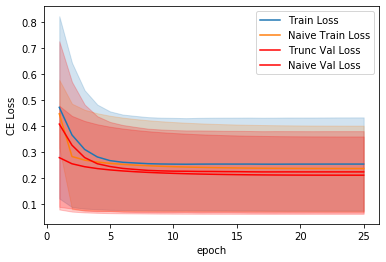

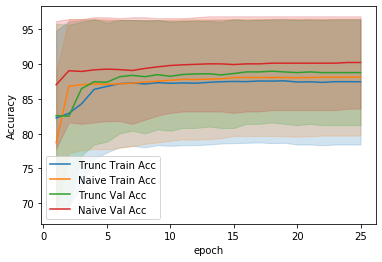

Standard Test Accuracy: 0    86.714119
0    91.197845
Name: test_prec1, dtype: float64
Truncated Test Accuracy: 0    84.460258
0    88.990578
Name: test_prec1, dtype: float64


In [40]:
# plot results
plot()

# Cosine Similarity and L2 Distance

In [41]:
print("cosine trunc weight: {}".format(ch.nn.functional.cosine_similarity(trunc_multi_log_reg.weight, ground_truth.weight)))
print("cosine trunc bias: {}".format(ch.nn.functional.cosine_similarity(trunc_multi_log_reg.bias.unsqueeze(0), ground_truth.bias.unsqueeze(0))))

cosine trunc weight: tensor([0.9648, 0.8076], grad_fn=<DivBackward0>)
cosine trunc bias: tensor([-0.5544], grad_fn=<DivBackward0>)


In [42]:
print("cosine standard weight: {}".format(ch.nn.functional.cosine_similarity(standard_multi_log_reg.weight, ground_truth.weight)))
print("cosine standard bias: {}".format(ch.nn.functional.cosine_similarity(standard_multi_log_reg.bias.unsqueeze(0), ground_truth.bias.unsqueeze(0))))

cosine standard weight: tensor([0.9999, 0.9944], grad_fn=<DivBackward0>)
cosine standard bias: tensor([-0.9223], grad_fn=<DivBackward0>)


In [43]:
print("cosine gumbel ce weight: {}".format(ch.nn.functional.cosine_similarity(gumbel_ce_multi_log_reg.weight, ground_truth.weight)))
print("cosine gumbel ce bias: {}".format(ch.nn.functional.cosine_similarity(gumbel_ce_multi_log_reg.bias.unsqueeze(0), ground_truth.bias.unsqueeze(0))))

cosine gumbel ce weight: tensor([0.9987, 0.9977], grad_fn=<DivBackward0>)
cosine gumbel ce bias: tensor([-0.7477], grad_fn=<DivBackward0>)
